## Description

This jupyter notebook aims to reproduce **Fig 6** from Section 4.2 of the manuscript and its respective figures in the supplementary material.

In this study we apply the PCMCI+ causal discovery algorithm to obtain causal networks connecting coupled and atmospheric modes of climate variability over
the Atlantic and Pacific for five 20-year subsequent windows within the 1950-2010 period.

We use the same indices as in section4_obs_reanalysis.ipynb (**TNA**,**Niño3.4**,**ATL3**,**PNA**,**NAO**,**PWCu**) but here calculated from:
- [CESM Atlantic pacemaker ensemble](https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.ATL-PACEMAKER.atm.proc.monthly_ave.html) with 10 simulations


| **Index**         | **Definition**             | **Region**                                      |
|---------------|-------------------------------------------------------|---------------------------------------------|
| **TNA**           | Area-weighted monthly SSTAs over the North Tropical Atlantic region              | 5.5–23.5°N, 58°–15°W                       |
| **Niño3.4**      | Area-weighted monthly SSTAs over the equatorial Pacific region                       | 5°N–5°S, 170°–120°W                         |
| **PNA**           | Leading EOF of (3-monthly averaged and area-weighted) SLP anomalies over the Pacific North America region | 20–85°N, 120°E–120°W     |
| **NAO**           | Leading EOF of (3-monthly averaged and area-weighted) SLP anomalies over the North Atlantic region | 20–80°N, 90°W-40°E         |
| **PWCu**     | Monthly zonal wind anomaly at 925 hPa  (or nearest available level) over the equatorial Pacific region             | 6°N–6°S, 180°-150°E  |
| **ATL3**          | Area-weighted monthly SSTAs over the equatorial Atlantic region                   | 3°N–3°S, 20°W–0°                            |
| AMV           | Monthly SSTAs averaged over the North Atlantic region                                 | 0–60°N, 80–0°W                             |
| PDV           | PC associated with 1st EOF of area-weighted monthly SSTAs over the North Pacific region| 20–70°N, 110°E–100°W                      |

**Multidata-PCMCI Functionality:**  
  We use this functionality here to produce results based on the whole ensemble. Details on the Multidata-PCMCI functionality can be found on Tigramite's [GitHub repository](https://github.com/jakobrunge/tigramite/blob/master/tutorials/dataset_challenges/tigramite_tutorial_multiple_datasets.ipynb) (last access: 29 April 2024).
  
## I. Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings while loading
import numpy as np
from utils import Utils as utils
from data_visualization import DataVisualization
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI
from tigramite.data_processing import DataFrame
import xarray as xr
import seaborn as sns
import pickle
import concurrent.futures
from run_causal_analysis import run_sliding_window as rsw

## II. Settings and Parameters

In [3]:
# Parameters for the analysis and plotting

detrend = False
smooth = False
stddz = False
seasonal = True
min_tau, max_tau = 0, 4
var_names = ["$TNA$", "$PNA$", "$Nino34$", "$PWC_{u}$", "$NAO$", "$ATL3$"]  #
x = np.array([110, 10, 5, 18, 117, 130])  # degree to the east
y = np.array([13.5, 52, 0, 14, 52, 0])  # degree to the south (therefore negative)

FIGS_DIR="FIGS/ATL_pacemaker/"
DF_DIR="DATA/ATL_pacemaker/"

DataVisualization.create_directories(FIGS_DIR,DF_DIR)

perioda=['1950-01-01','2014-12-01']


Directory 'FIGS/ATL_pacemaker/' already exists!
Directory 'DATA/ATL_pacemaker/' already exists!


## III. Load datasets, calculate indices and prepare dataframes

#### **! Adjust path to data and file names accordingly !**

In [4]:
# Paths to the observational and ensemble mean data
path_to_psl_em = "/work/bd1083/b380749/esmval/recipe_EM_psl_20230323_234348/preproc/dummy_diagnostic_1/psl/"
path_to_ua_em = "/work/bd1083/b380749/esmval/recipe_EM_20230323_233618/preproc/dummy_diagnostic_1/ua/"
path_to_ts_em = "/work/bd1083/b380749/esmval/recipe_EM_ts_20230323_234348/preproc/dummy_diagnostic_1/ts_landmask/"

path_to_psl_atl="/work/bd1083/b380749/b380749/NetCDF/ATLANTIC_PACEMAKER/PSL/"
path_to_ua_atl="/work/bd1083/b380749/b380749/NetCDF/ATLANTIC_PACEMAKER/UA/"
path_to_ts_atl="/work/bd1083/b380749/b380749/NetCDF/ATLANTIC_PACEMAKER/TS/"

# create empty dictionaries to store data
amv_EM_ATL= dict()
amv_EM_ATL_iso= dict()
amv_EM_ATL_veryraw= dict()
pdv_EM_ATL= dict()
pdv_EM_ATL_iso= dict()
pdv_EM_ATL_veryraw= dict()

# Load the datasets
ds_psl_em = xr.open_dataset(
    path_to_psl_em
    + "CMIP6_MultiModelMean_historical_EnsembleMean_Amon_psl_1900-2014.nc"
).sel(time=slice('1950-01-15', '2013-12-15'))# 
ds_ua_em = xr.open_dataset(
    path_to_ua_em + "CMIP6_MultiModelMean_historical_EnsembleMean_Amon_ua_1900-2014.nc"
).sel(plev=92500).sel(time=slice('1950-01-15', '2013-12-15'))#
    

ds_ts_em = xr.open_dataset(
    path_to_ts_em + "CMIP6_MultiModelMean_historical_EnsembleMean_Amon_ts_1900-2014.nc"
).sel(time=slice('1950-01-15', '2013-12-15'))#

T, N = len(ds_ts_em['time'].resample(time="QS-DEC", keep_attrs=True).mean().values[1:]), len(var_names)
data_EM_ATL= np.zeros((10, T, N))
data_EM_ATL_iso= np.zeros((10, T, N))

def partial_func(ensm):
    """
    Load the data and calculate the indices

    !!!!! Please adjust the paths to the data and file names if necessary !!!!!
    """
    fensm = "{:02d}".format(ensm)
    ts_nc=path_to_ts_atl+"b.e11.B20TRLENS.f09_g16.SST.restoring.NATL.1920.ens"+fensm+".cam.h0.TS.192001-201312.nc"
    ua_nc=path_to_ua_atl+"b.e11.B20TRLENS.f09_g16.SST.restoring.NATL.1920.ens"+fensm+".cam.h0.U.192001-201312.nc"
    psl_nc=path_to_psl_atl+"b.e11.B20TRLENS.f09_g16.SST.restoring.NATL.1920.ens"+fensm+".cam.h0.PSL.192001-201312.nc"
    return rsw.load_and_calculate_indices_ATLANTIC(ensm,ds_ts_em=ds_ts_em,ds_ua_em=ds_ua_em,
                                                  ds_psl_em=ds_psl_em,ts_nc=ts_nc,ua_nc=ua_nc,psl_nc=psl_nc,T=T,N=N)

with concurrent.futures.ProcessPoolExecutor() as executor:
        for i, tig_data_ATL, tig_data_ATL_iso, amv_dict, \
        amv_dict_iso, amv_dict_veryraw, pdv_dict, pdv_dict_iso,\
        pdv_dict_veryraw, yearsarrobs in executor.map(partial_func, range(1, 11)):
                amv_EM_ATL[i] = amv_dict
                amv_EM_ATL_iso[i] = amv_dict_iso
                amv_EM_ATL_veryraw[i] = amv_dict_veryraw
                pdv_EM_ATL[i] = pdv_dict
                pdv_EM_ATL_iso[i] = pdv_dict_iso
                pdv_EM_ATL_veryraw[i] = pdv_dict_veryraw
                data_EM_ATL[i]=tig_data_ATL
                data_EM_ATL_iso[i]=tig_data_ATL_iso
            
np.save(file=DF_DIR+'data_EM_ATL.npy', arr=data_EM_ATL)
np.save(file=DF_DIR+'data_EM_ATL_iso.npy', arr=data_EM_ATL_iso)

file_names = ['pdv_EM_ATL_veryraw.pickle', 'pdv_EM_ATL.pickle', 'pdv_EM_ATL_iso.pickle',
              'amv_EM_ATL_veryraw.pickle', 'amv_EM_ATL.pickle', 'amv_EM_ATL_iso.pickle']
data = [pdv_EM_ATL_veryraw, pdv_EM_ATL, pdv_EM_ATL_iso, amv_EM_ATL_veryraw, amv_EM_ATL, amv_EM_ATL_iso]

for file_name, data_obj in zip(file_names, data):
    with open(DF_DIR+file_name, 'wb') as handle:
        pickle.dump(data_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

####################### ATL pac04
####################### ATL pac08
####################### ATL pac01
####################### ATL pac02
####################### ATL pac09
####################### ATL pac03
####################### ATL pac05
####################### ATL pac07
####################### ATL pac10
####################### ATL pac06


In [5]:

pickle_files = ['amv_obs_dict', 'amv_obs_dict_veryraw', 'amv_obs_dict_iso',
                'pdv_obs_dict','pdv_obs_dict_veryraw','pdv_obs_dict_iso',]

for file in pickle_files:
    with open('/work/bd1083/b380749/karmouche24esd_AtlanticPacific_Pacemaker/DATA/OBS/'+file+'.pickle', 'rb') as f:
        globals()[file] = pickle.load(f)
    

#### Flip PDV sign if needed (EOF signs are arbitrary!)
Attempt to unify the sign between ensemble members with respect to OBS patterns 

In [6]:
for ensm in range(1,11):
    pdv_dict=pdv_EM_ATL[ensm-1]
    pdv_dict_iso=pdv_EM_ATL_iso[ensm-1]
    pdv_dict_veryraw=pdv_EM_ATL_veryraw[ensm-1]
    if (np.corrcoef(pdv_dict['pdv_timeseries'].resample(time='QS-DEC', keep_attrs=True).mean()[1:], data_EM_ATL[ensm-1, :, 2])[0,1]) < 0: 
        pdv_dict['pdv_timeseries']*=-1
    if (np.corrcoef(pdv_dict_iso['pdv_timeseries'].resample(time='QS-DEC', keep_attrs=True).mean()[1:], data_EM_ATL_iso[ensm-1, :, 2])[0,1]) < 0:
        pdv_dict_iso['pdv_timeseries']*=-1
    if (np.corrcoef(pdv_dict_veryraw['pdv_timeseries'].resample(time='QS-DEC', keep_attrs=True).mean()[1:], data_EM_ATL_iso[ensm-1, :, 2] )[0,1]) < 0:
        pdv_dict_veryraw['pdv_timeseries']*=-1 

### Plot AMV and PDV

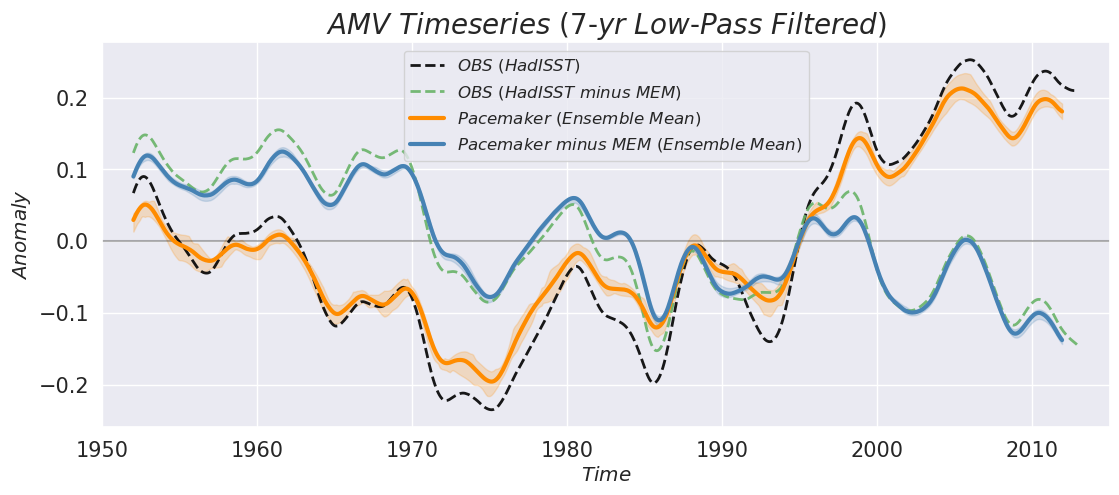

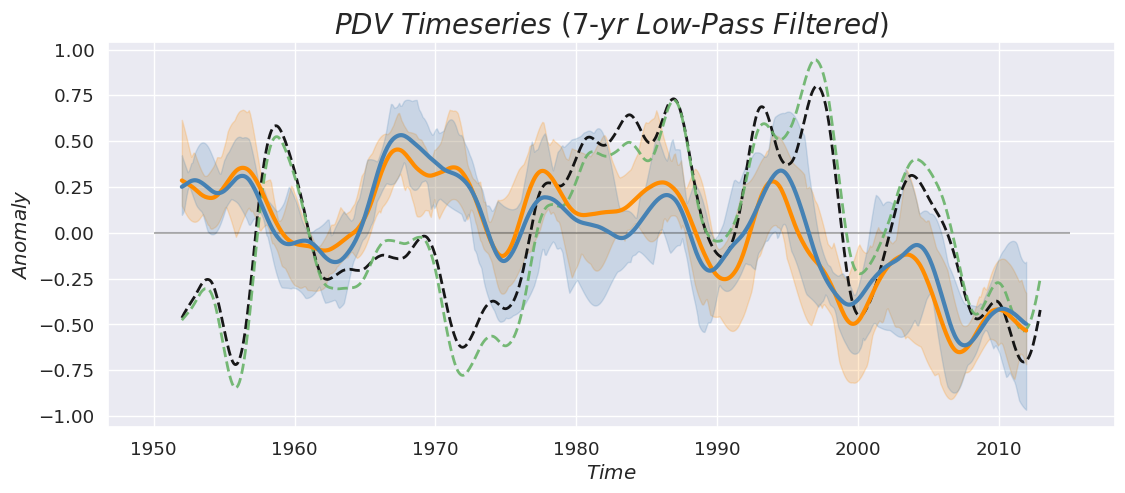

In [7]:
sns.set(style="darkgrid", font_scale=1.2)
dec_yearsarrobs=amv_obs_dict['amv_timeseries_lp']['time.year'].values

DataVisualization.plot_amv_and_pdv_timeseries(amv_obs_dict_veryraw, amv_obs_dict_iso, amv_EM_ATL_veryraw, amv_EM_ATL_iso,
                                    pdv_obs_dict_veryraw, pdv_obs_dict_iso, pdv_EM_ATL_veryraw, pdv_EM_ATL_iso,
                                    dec_yearsarrobs, utils)

## IV. Plot time series (1950-2014)

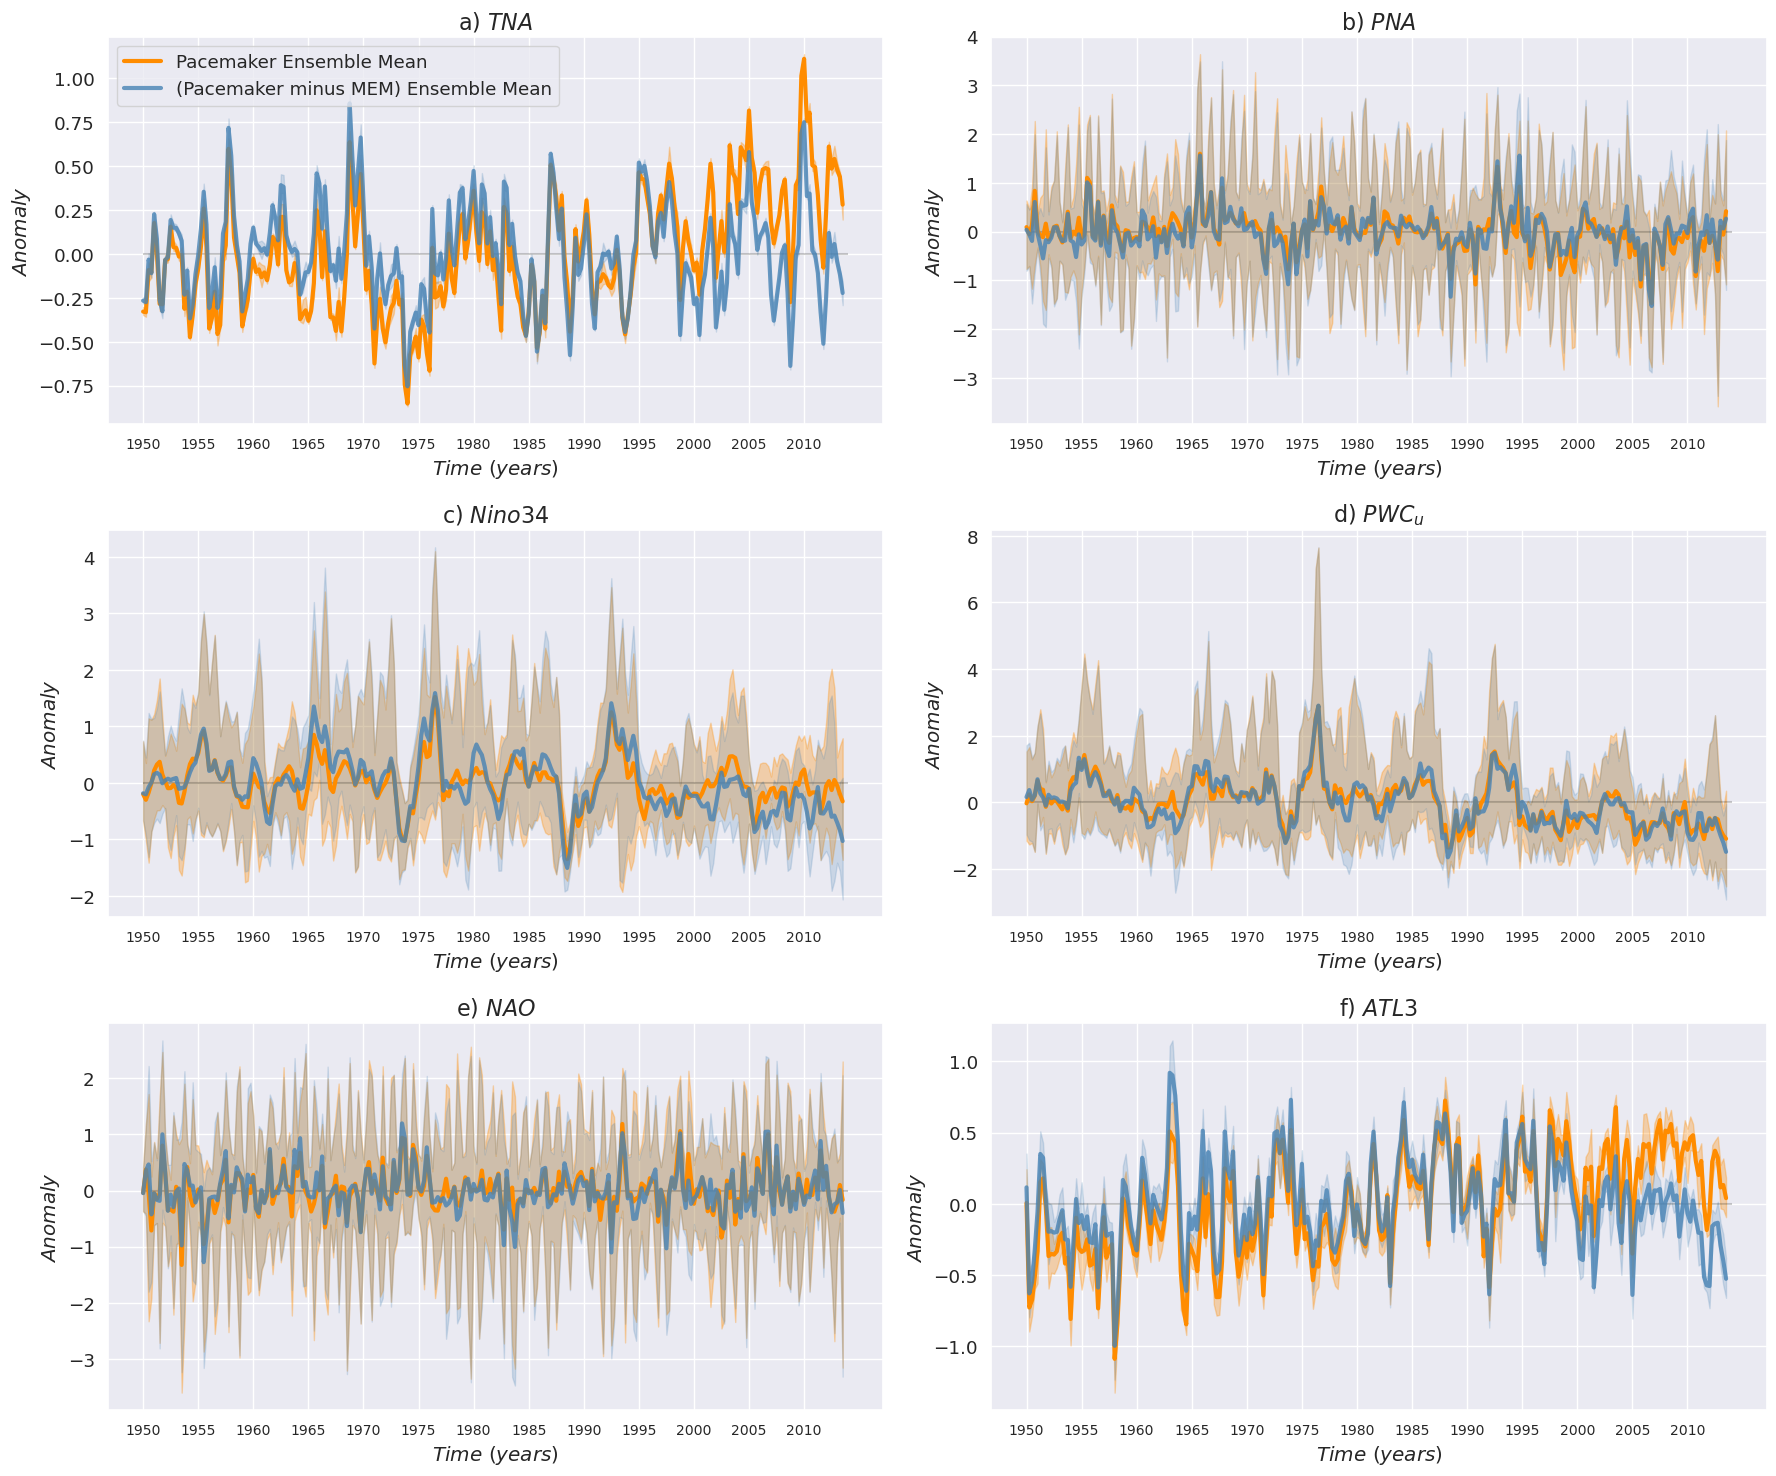

In [8]:
DataVisualization.plot_average_time_series(data_EM_ATL, data_EM_ATL_iso, yearsarrobs, var_names)

## V. Run sliding causal analysis using Multidata-PCMCI+ 

Set ```exp_data = data_EM_ATL_iso``` to use dataframe where MEM is removed before calculating the indices.

Set ```test_assumption=None ``` in ```rsw.run_analysis_sliding()``` to get results where no background knowledge is introduced

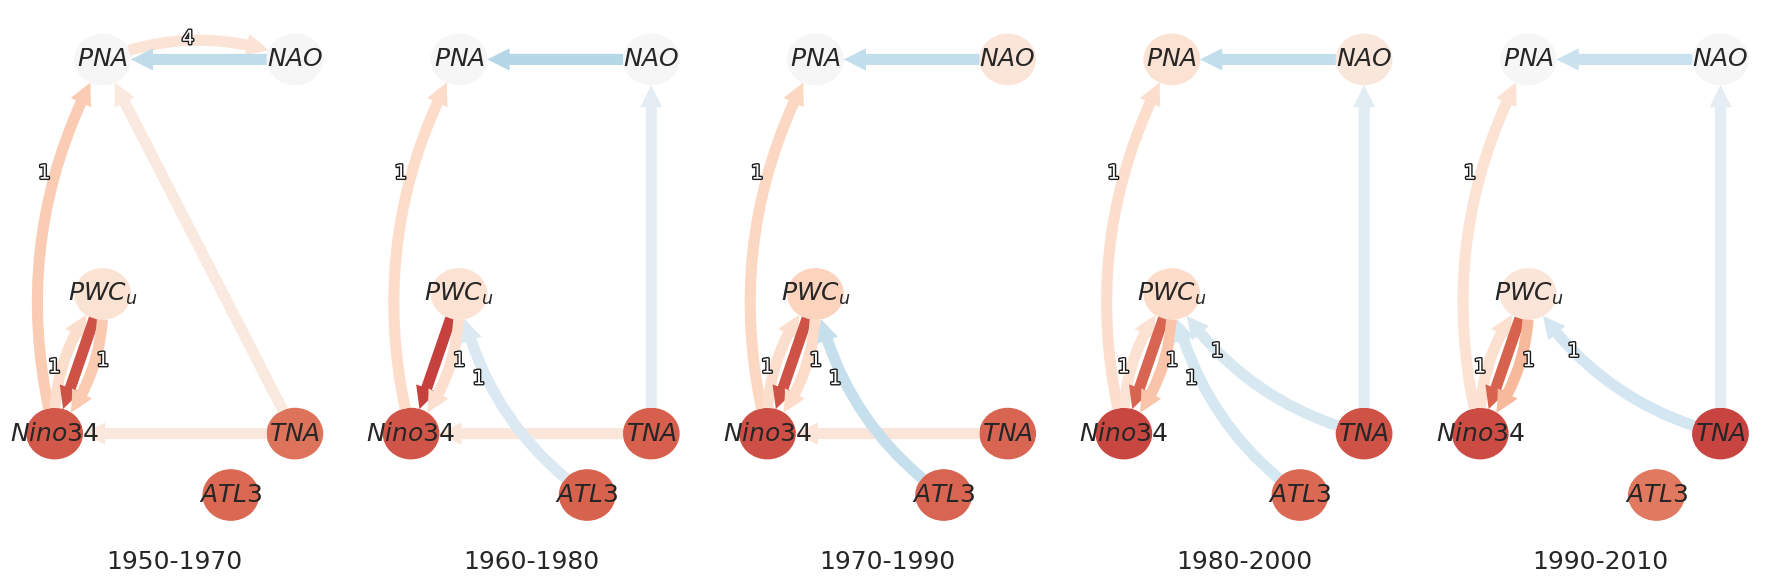

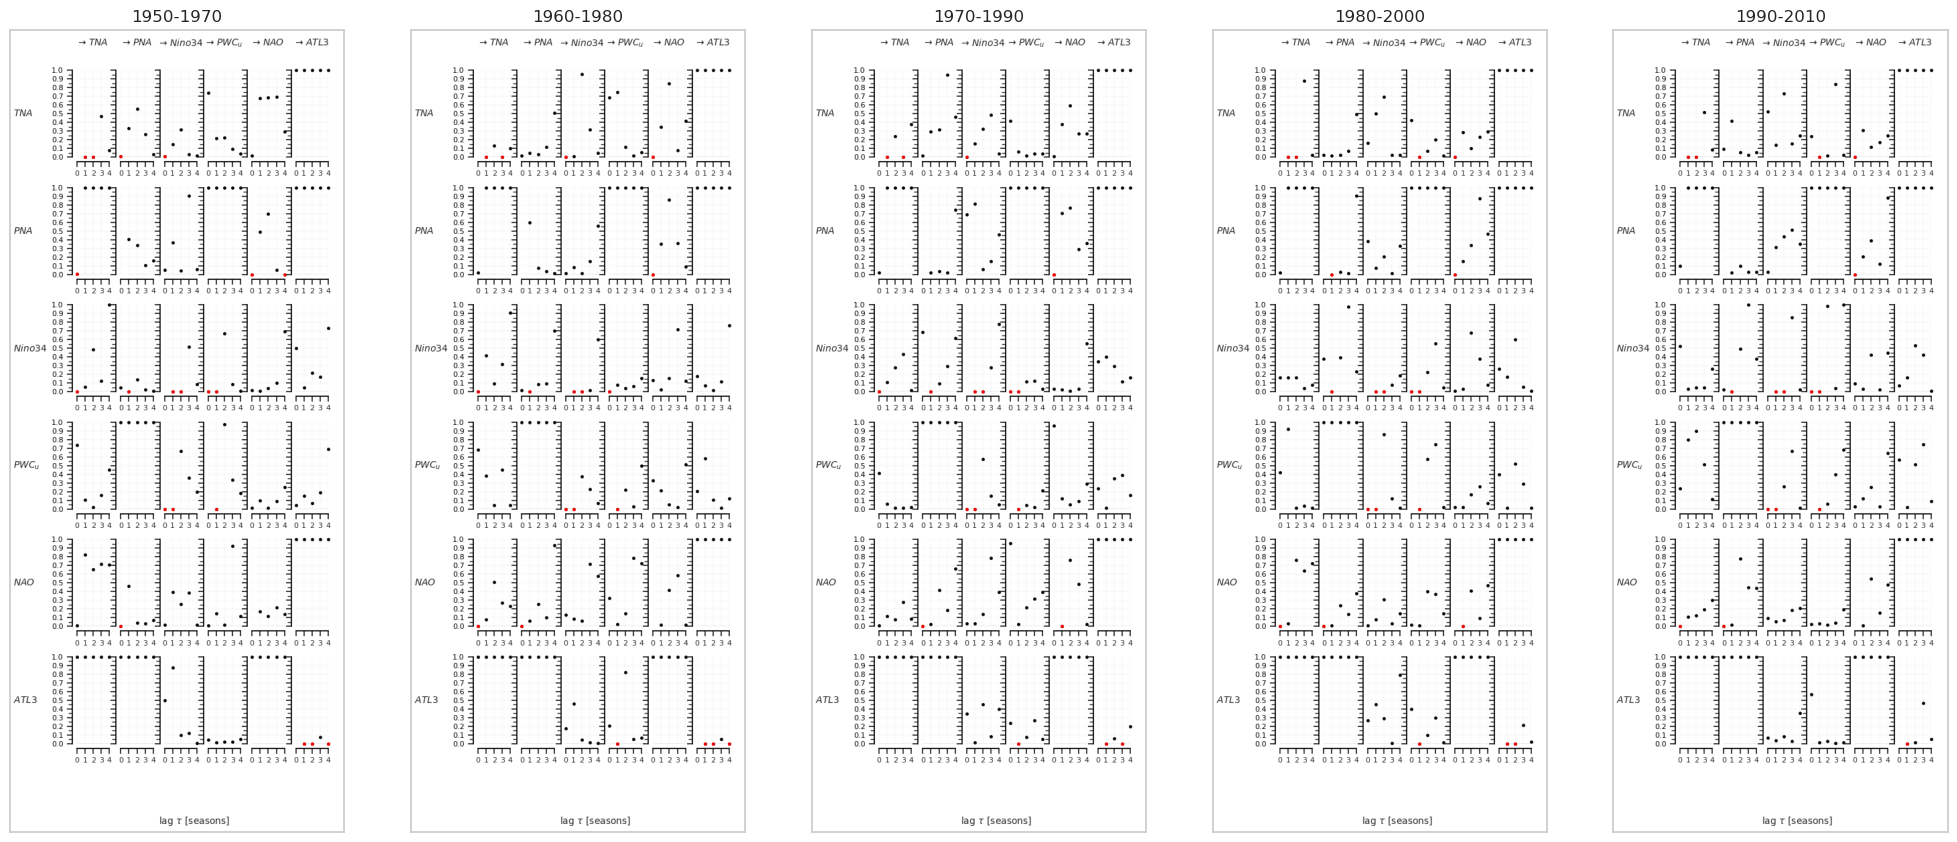

In [9]:
exp_data = data_EM_ATL # data_EM_ATL_iso
subtitles = ['1950-1970', '1960-1980', '1970-1990', '1980-2000', '1990-2010']
node_posld = {'x': np.array([ 10,   4,   2.5,    4 , 10, 8]),
            'y': np.array([  1.3,   8,     1.3,    3.8 ,  8, 0.2])}   # 
T, N = exp_data[0,:,:].shape
sns.set(style="whitegrid")
pc_alpha=0.01
min_tau=0
max_tau=4
if stddz == True:        
        for var in range(N):
                exp_data[:,var]=exp_data[:,var]/np.std(exp_data[:,var])      
if detrend==True:
    for i in range(N):
        exp_data[:,i]=utils.detrend_kw(exp_data[:,i])

window_step=40
window_length=80
dataframesld = DataFrame(exp_data, analysis_mode = 'multiple', var_names = var_names)
cond_ind_test = ParCorr(significance='analytic')#, mask_type='y')
pcmci = PCMCI(
    dataframe=dataframesld, 
    cond_ind_test=cond_ind_test,
    verbosity=0)

test_assumption= rsw.build_atlantic_assumption(max_tau,pcmci)

# Set test_assumption = None for results where no background knowledge is introduced
rsw.run_analysis_sliding(pcmci,
                      var_names=var_names, 
                      min_tau=min_tau, max_tau=4, pc_alpha=pc_alpha,
                       window_step=window_step, window_length=window_length, 
                       subtitles=subtitles, node_posld=node_posld,test_assumption=test_assumption,
                       FIGS_DIR=FIGS_DIR)
